In [2]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u

from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from scipy import signal
import pandas as pd
import matplotlib
from matplotlib import cm
import itertools

cysgp4.set_num_threads(16)

In [3]:

###reload here
reload(skynet)
reload(obs)
longitude = coord.Angle("111d55m11s").deg
latitude = coord.Angle("-27d23m37s").deg
elevation = 16 * u.m


loc1 = EarthLocation(longitude, latitude, elevation)
ant1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

# baseline=75 *u.m### m
longitude = coord.Angle("111d55m15s").deg
latitude = coord.Angle("-27d23m20s").deg
elevation = 16 * u.m
ant2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc2 = EarthLocation(longitude, latitude, elevation)

longitude = coord.Angle("111d40m08s").deg
latitude = coord.Angle("-27d30m20s").deg
elevation = 50 * u.m
ant3=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc3 = EarthLocation(longitude, latitude, elevation)

observers = np.array([ant1,ant2,ant3])

# x1,y1,z1 = pycraf.geospatial.wgs84_to_itrf2008(ant1.loc.lon*u.deg, ant1.loc.lat*u.deg, ant1.loc.alt*u.m)
# print(x1.value,y1,z1)

In [4]:
bearings,baselines = obs.baseline_pairs(observers)

for i in range(len(observers)):
    print(bearings[i],(baselines[i]))

print(obs.baseline_bearing(ant2,ant3))

###load the TLEs

[0. 0. 0.] 0.0
[-191.82470749  182.30556873  464.60220225] 534.684248065126
[ 25147.22338803   3897.00237978 -11008.09531362] 27726.298600957245
(array([ 25339.04809552,   3714.69681105, -11472.69751587]), 28062.236530181945)


### set up time and sky grid

In [5]:
niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 120*u.s, 1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 120, 1)


In [6]:
min_elevation = 30* u.deg
grid_size = 1 * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(44*u.deg ,46 * u.deg),
    lon_range=(140*u.deg,150*u.deg),
    rnd_seed=0,
    )
print(skygrid[2]["cell_lon_high"].shape)

#### a typical transmitter model, needed to setup 
# tx=obs.transmitter_info(p_tx_carrier=-44 * cnv.dBm, carrier_bandwidth=250*u.MHz, duty_cycle=100 * u.percent, d_tx=1*u.m,freq=10.95*u.GHz)
# p_tx=tx.power_tx(10.7*u.GHz)
# print(p_tx)


(14,)


In [7]:
# ##load some tle from starlink
# import requests
# url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=oneweb&FORMAT=tle'
# ctrak_oneweb = requests.get(url).text

# tle_list = cysgp4.tle_tuples_from_text(ctrak_oneweb)

###load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

In [8]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])  # use which TLEs
tles=np.random.choice(a=tles,size=4000)
print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 4000 satellites over 1.0 days,
each day/epoch contains 120.0 integrations over 120.0 s seconds
(4000,)


In [9]:
dish=25*u.m
eta=0.5 *100*u.percent ## in percentage
# ### frequency band
# ## transmitter parameters
# ### observatory list will be passed on internally like this

rx=obs.receiver_info(dish,eta,observers,freq=10700*u.MHz,bandwidth=1*u.MHz)

1.2589254117941673 W / (Hz m2)


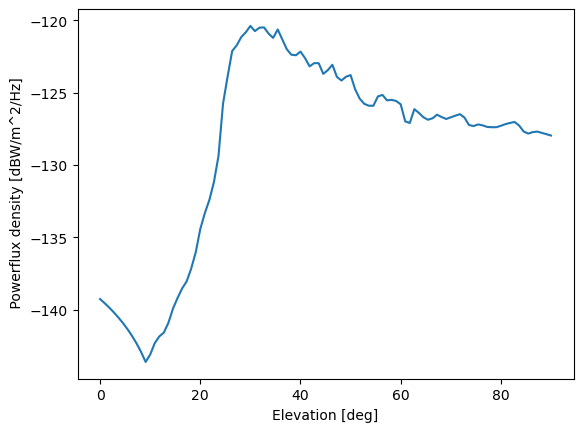

In [10]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz)/u.Hz ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2_Hz)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2/Hz]')
plt.xlabel('Elevation [deg]')
plt.show()

### array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites

In [11]:
test=obs.obs_sim(rx,skygrid,mjds)
print(test.location)
print(test.grid_az.shape)

[[[[[[<PyObserver: 111.9197d, -27.3936d, 0.0160km>]]]]]




 [[[[[<PyObserver: 111.9208d, -27.3889d, 0.0160km>]]]]]




 [[[[[<PyObserver: 111.6689d, -27.5056d, 0.0500km>]]]]]]
(1, 1, 14, 1, 1, 1)


In [12]:
## if first time run the populate function to create coordinates
# test.populate(tles,save=True,savename='starlink_1s.npz')  

test.load_propagation(nparray="starlink_1s.npz")
### cut the whole array using the same method
test.reduce_sats(el_limit=10)
nsat=11
print('check array shapes below')
print('sat_frame az',test.satf_az.shape)
print('sat_frame el',test.satf_el.shape)

check array shapes below
sat_frame az (3, 1, 1, 1, 120, 56)
sat_frame el (3, 1, 1, 1, 120, 56)


In [13]:
### get one satellite

sat_dist=test.satf_dist[:,:,:,:,:,:]
time_2d = Time(mjds, format='mjd')

#### setting up the altaz frame for the antennas
#### also get the 1-d arrays of the satellite location in altaz frame
sat_az=test.topo_pos_az
sat_el=test.topo_pos_el
# print(loc1.shape,time_2d.shape)
altaz=AltAz(obstime=time_2d,location=loc1)
sat_coord=SkyCoord(sat_az*u.deg,sat_el*u.deg,frame=altaz)[0,:,:,:,:,:][np.newaxis,:]
sat_az=test.topo_pos_az[0,:,:,:,:,:][np.newaxis,:]
sat_el=test.topo_pos_el[0,:,:,:,:,:][np.newaxis,:]
print(sat_coord.shape)

(1, 1, 1, 1, 120, 56)


[[[[197.07996262]]]]
(1, 1, 1, 1, 120, 1) (1, 1, 1, 1, 120, 56) (1, 1, 1, 1, 120, 1)


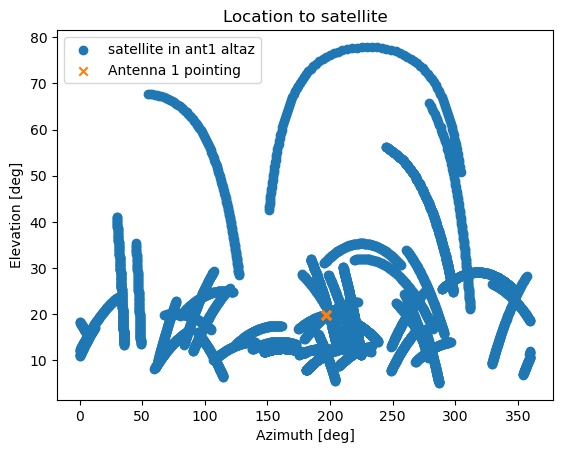

In [25]:
idx_t=60
### we pick a satellite location here and make the telescope intercept it at that idx_t time during a normal ra dec observation

pnt=sat_coord[:,:,:,:,idx_t,nsat]
ra=pnt.transform_to('icrs').ra.deg
dec=pnt.transform_to('icrs').dec.deg
# tel_pnt=test.sky_track(ra,dec)
print(sat_az[:,:,:,:,idx_t,nsat])




# tel_pnt=test.sky_track(sat_az[idx_t],sat_el[idx_t],frame=altaz) 
tel_pnt=test.azel_track(pnt.az,pnt.alt) ### use this satellite position for pointing
# tel_pnt=sat_coord[idx_t]
tel_az=tel_pnt.az.deg
tel_el=tel_pnt.alt.deg
# print(tel_az)
print(tel_pnt.shape,sat_el.shape,tel_az.shape)
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Location to satellite')
plt.scatter(sat_az.flatten(),sat_el.flatten(),label='satellite in ant1 altaz')
plt.scatter(tel_az,tel_el,marker='x',color='C1',label='Antenna 1 pointing')
plt.legend()
plt.show()

(2334,) (1, 1, 1, 1, 120, 56)
197.07996261985542 19.793924026613272


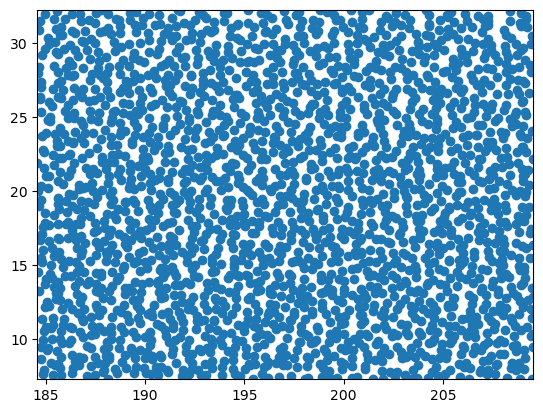

In [26]:
grid_size = 30 * u.arcmin
### make a smaller grid and replace the parameters in the object, a bit of a hack.
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lon_range=((tel_az.flatten()[idx_t]-12.5)*u.deg ,(tel_az.flatten()[idx_t]+12.5) * u.deg),
    lat_range=((tel_el.flatten()[idx_t]-12.5)*u.deg,(tel_el.flatten()[idx_t]+12.5)*u.deg),
    rnd_seed=0,
                          randome=True
    )
grid_az, grid_el, test.grid_info = skygrid
test.grid_az=grid_az[np.newaxis,:,:,np.newaxis,np.newaxis,np.newaxis]
test.grid_el=grid_el[np.newaxis,:,:,np.newaxis,np.newaxis,np.newaxis]
print(grid_az[0].shape,sat_coord.shape)
print(tel_az.flatten()[idx_t],tel_el.flatten()[idx_t])



plt.scatter(grid_az,grid_el)
plt.xlim(grid_az.min(),grid_az.max())
plt.ylim(grid_el.min(),grid_el.max())
plt.show()


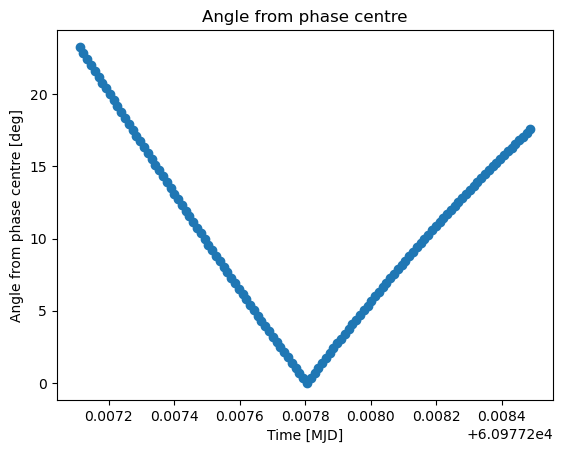

In [41]:
plt.title('Angle from phase centre')
offbeam=tel_pnt.separation(sat_coord)
# print(np.argmin(offbeam,axis=4))
# offbeam[:np.argmin(offbeam,axis=4)]*=-1
timex=mjds.flatten()
plt.scatter(timex,offbeam.reshape(len(timex),-1)[:,nsat])
plt.xlabel('Time [MJD]')
plt.ylabel('Angle from phase centre [deg]')
plt.show()


### plot far field fringe ripples on the sky


In [42]:
pnt_xy = SkyCoord(tel_az.flatten()[idx_t],tel_el.flatten()[idx_t],unit=(u.deg,u.deg))


### use fake grid
az=np.linspace(tel_az.flatten()[idx_t]-5,tel_az.flatten()[idx_t]+5,1000)
el=np.linspace(tel_el.flatten()[idx_t]-5,tel_el.flatten()[idx_t]+5,1000)
az,el=np.meshgrid(az,el)
ew_grid=pnt_xy.separation(SkyCoord(az,el,unit=(u.deg,u.deg)))


###use the sky grid instead of fake grid
ew_grid=pnt_xy.separation(SkyCoord(grid_az[0],grid_el[0],unit=(u.deg,u.deg)))
print(pnt_xy,ew_grid.shape)

### Note!!! VERY IMPORTANT this is the the fringe attenuation of that instance during intercept

<SkyCoord (ICRS): (ra, dec) in deg
    (197.07996262, 19.79392403)> (2334,)


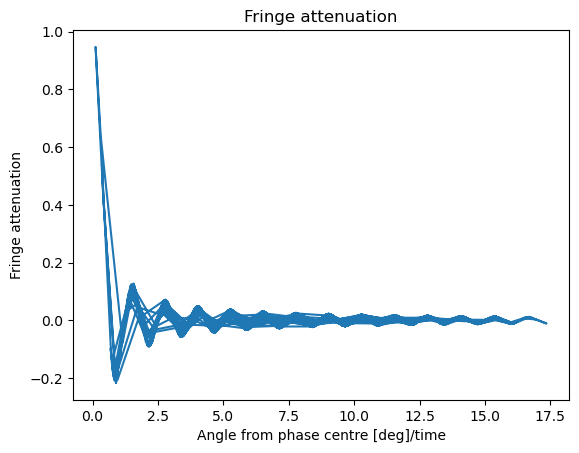

(2334,)


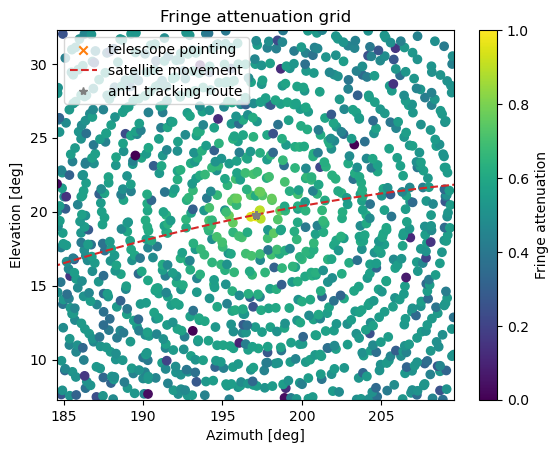

In [43]:
plt.title('Fringe attenuation')
fringe_attenuation=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=ew_grid.flatten(),bandwidth=1*u.MHz)
plt.plot(ew_grid.value.flatten(), fringe_attenuation)
plt.xlabel('Angle from phase centre [deg]/time')
plt.ylabel('Fringe attenuation')
plt.show()


# fringe_grid=ew_grid.value
fringe_grid=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=ew_grid,bandwidth=1*u.MHz)
print(fringe_grid.shape)
plt.scatter(pnt_xy.ra.deg,pnt_xy.dec.deg,marker='x',label='telescope pointing',color='C1')
plt.plot(sat_az[0,0,0,0,:,nsat],sat_el[0,0,0,0,:,nsat],'--',color='C3',label='satellite movement')
plt.plot(tel_az.flatten(),tel_el.flatten(),'*',label='ant1 tracking route',color='C7')

norm=matplotlib.colors.LogNorm(vmin=1e-4,vmax=1.1)
colors=cm.viridis(norm(fringe_grid))
plt.scatter(grid_az[0],grid_el[0],color=colors)
plt.colorbar(label='Fringe attenuation')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Fringe attenuation grid')
plt.xlim(grid_az.min(),grid_az.max())
plt.ylim(grid_el.min(),grid_el.max())
plt.legend()
plt.savefig('satellite transit fringe far field attenuation.png')
plt.show()

### we now calculate the delays of the source in the baseline


##### we first calculate the tel_delay value is to account for the telescope delay offset at a certain direction
##### real_delay is the satellite's delay into the system during a farfield pointing observation 
##### we also calculate the actual satellite delays and the baseline delays

telescope pointing delay array shape: (3, 1, 1, 1, 120, 1)
satellite delay array shape: (3, 1, 1, 1, 120, 56)


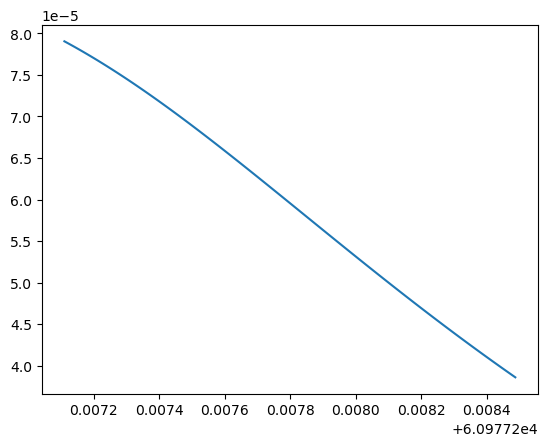

In [44]:
tel_delays=obs.mod_tau(az=tel_az,el=tel_el,lat=ant1.loc.lat,
                       D=baselines[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis]*u.m) ### baseline directional delay
print('telescope pointing delay array shape:',tel_delays.shape)
satdelays=((sat_dist[0][np.newaxis,:]*1000/3e8)-(sat_dist*1000/3e8))*u.s ### satellite signal delay between two elements

# satdelays=satdelays.reshape(len(timex),-1)[:,nsat]

### calculate the remaining satellite delay that appears in the system
real_delays=obs.baseline_nearfield_delay(
                                         l1=sat_dist[0][np.newaxis,:]*u.km,l2=sat_dist*u.km,tau=tel_delays) ### tau adds in the telescope directional delay
print('satellite delay array shape:',satdelays.shape)

delays=satdelays-tel_delays



plt.plot(mjds.flatten(),satdelays[2,0,0,0,:,nsat])
### sanity check of your delay calculations
# plt.plot(mjds.flatten(),tel_delays)
# plt.plot(mjds.flatten(),real_delays-satdelays) ### this should be same as tel_delays
plt.show()

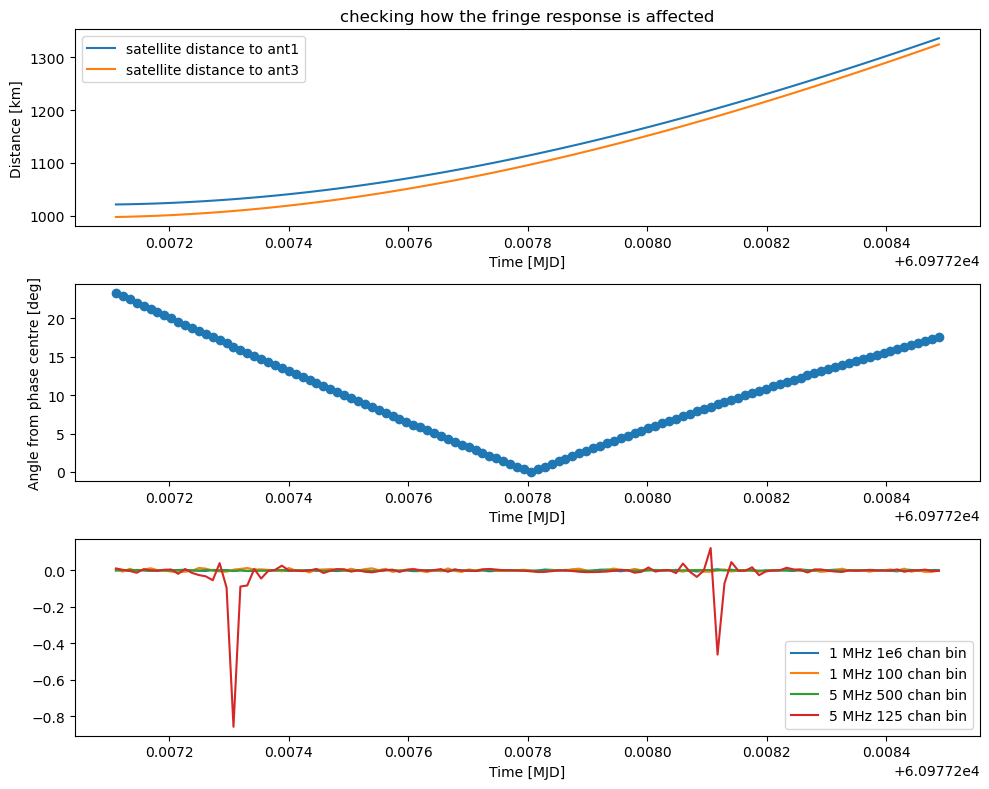

In [49]:
plt.figure(figsize=(10, 8))


ax1=plt.subplot(311)
ax1.set_title('checking how the fringe response is affected')

ax1.plot(mjds.flatten(),sat_dist[0,0,0,0,:,nsat],label='satellite distance to ant1')
ax1.plot(mjds.flatten(),sat_dist[2,0,0,0,:,nsat],label='satellite distance to ant3')
ax1.legend()
ax1.set_xlabel('Time [MJD]')
# ax1.set_ylabel('Fringe response')
ax1.set_ylabel('Distance [km]')
ax2=plt.subplot(312)
plt.scatter(mjds.flatten(),offbeam.reshape(len(timex),-1)[:,nsat])
ax2.set_xlabel('Time [MJD]')
ax2.set_ylabel('Angle from phase centre [deg]')
ax3=plt.subplot(313)
ax3.plot(mjds.flatten(),obs.bw_fringe(delays=satdelays[2,0,0,0,:,nsat],
                                               bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100000),label='1 MHz 1e6 chan bin')
ax3.plot(mjds.flatten(),obs.bw_fringe(delays=satdelays[2,0,0,0,:,nsat],
                                               bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100),label='1 MHz 100 chan bin')
ax3.plot(mjds.flatten(),obs.bw_fringe(delays=satdelays[2,0,0,0,:,nsat],
                                               bwchan=5*u.MHz,fch1=100*u.MHz,chan_bin=500),label='5 MHz 500 chan bin')
ax3.plot(mjds.flatten(),obs.bw_fringe(delays=satdelays[2,0,0,0,:,nsat],
                                               bwchan=5*u.MHz,fch1=100*u.MHz,chan_bin=125),label='5 MHz 125 chan bin')

ax3.set_xlabel('Time [MJD]')

plt.legend()
plt.tight_layout()
plt.savefig('fringe shift example.png')
plt.show()

#### the below is an integration of 100-150 MHz with 1 MHz channel fringes, 
#### you can see that the fringes are washed out (1e-3 attenuation scale), therefore we should focus on a single integration channel

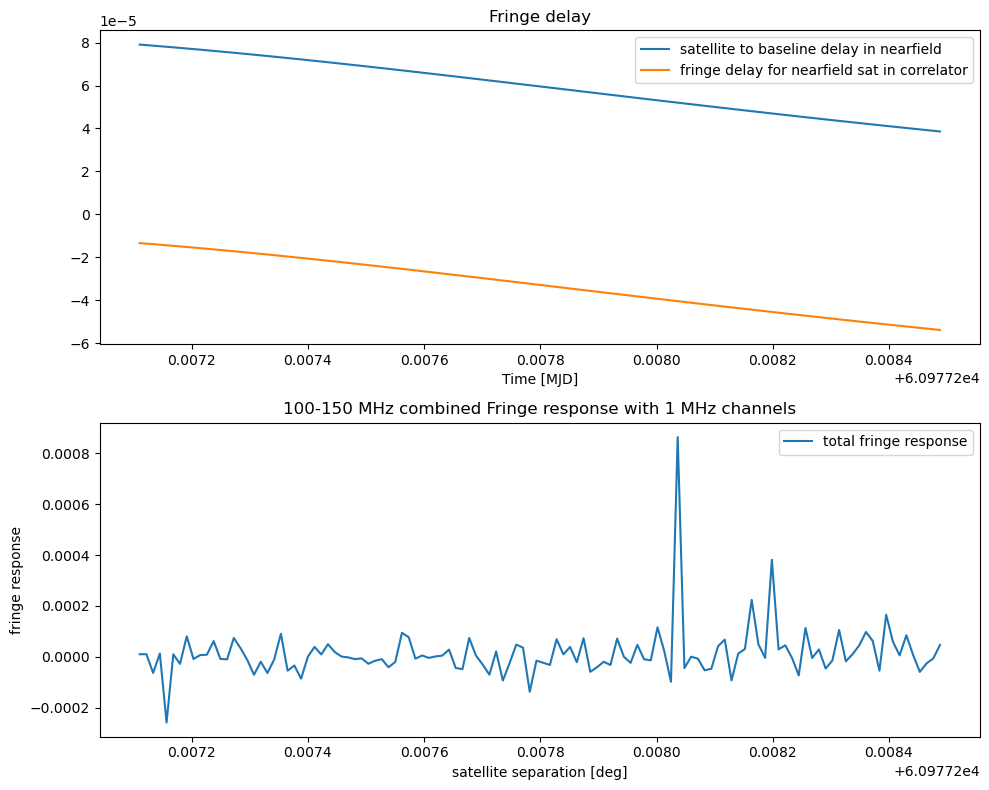

In [34]:

plt.figure(figsize=(10, 8))
ax1=plt.subplot(211)
ax1.plot(mjds.flatten(), satdelays[2,0,0,0,:,nsat],label='satellite to baseline delay in nearfield')
ax1.plot(mjds.flatten(), real_delays[2,0,0,0,:,nsat],label='fringe delay for nearfield sat in correlator')
ax1.set_xlabel('Time [MJD]')
ax1.set_title('Fringe delay')
ax1.legend()


ax2=plt.subplot(212,sharex=ax1)
powerfringe=np.zeros(len(mjds.flatten())) ### this will collect the power
bands=np.arange(100,150,1)*u.MHz
for fch1 in bands:
    bwfringe=obs.bw_fringe(delays=satdelays[2,0,0,0,:,nsat],bwchan=1*u.MHz,fch1=fch1,chan_bin=1000)
    powerfringe+=(bwfringe) ### consider equal power is equal

ax2.plot(mjds.flatten(), powerfringe/len(bands),label='total fringe response')

ax2.set_xlabel('satellite separation [deg]')

ax2.set_ylabel('fringe response')
ax2.set_title('100-150 MHz combined Fringe response with 1 MHz channels')
ax2.legend()


plt.tight_layout()
plt.show()

In [35]:
plt.close()
star_el=test.topo_pos_el
print(star_el.shape)
### get power from satellite
satpwrpfd=(np.interp(star_el,xp=x_el,fp=y_pfd)).to(u.W/u.m**2/u.Hz)*10e6*u.Hz ###10 MHz bandwidth power
print(satpwrpfd.shape)

(3, 1, 1, 1, 120, 56)
(3, 1, 1, 1, 120, 56)


#### calculate the angle separations of sources during observation

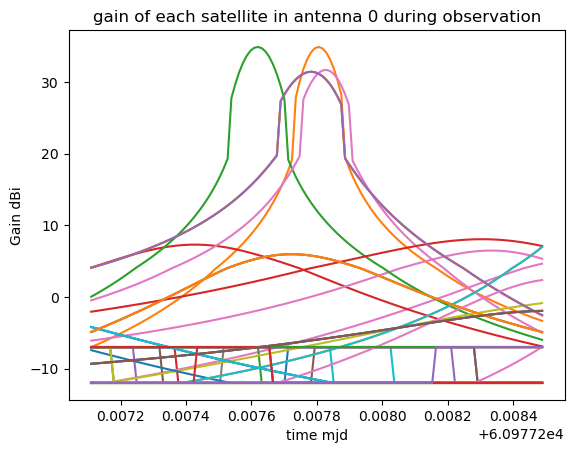

In [50]:
#### create the gain change over time
ang_sep=test.sat_separation(mode='pnt',pnt_az=tel_az,pnt_el=tel_el)

g_rx=antenna.ras_pattern(ang_sep,rx.d_rx,const.c/300e6*u.s,rx.eta_a_rx) ###.to(cnv.dimless) ## get linear
plt.title('gain of each satellite in antenna 0 during observation')
plt.plot(mjds.flatten(),g_rx[0,0,0,0,:,:])
plt.ylabel('Gain dBi')
plt.xlabel('time mjd')
plt.show()

In [51]:
test.create_baselines() ### create baselines within object

(3, 1, 1, 1, 120, 56) (1, 1, 1, 1, 120, 1) (3, 1, 1, 1, 120, 1) (3, 1, 1, 1, 1, 1)
(3, 120, 56)


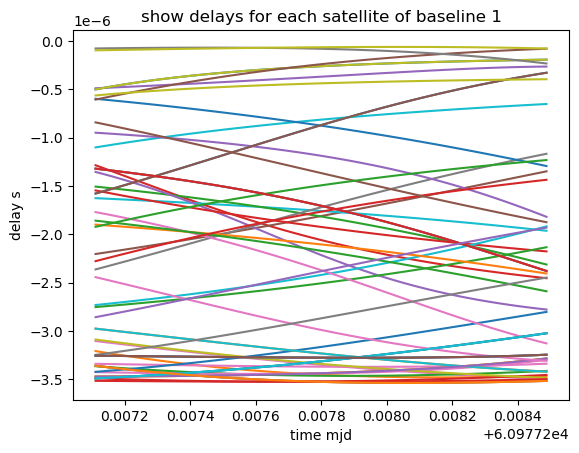

In [52]:
baseline_delays=test.baselines_nearfield_delays()
print(baseline_delays.shape,test.pnt_az.shape,test.pnt_tau.shape,test.bearing_D.shape)
# 

delays=baseline_delays[:,0,0,0,:,:]
print(delays.shape)
plt.title('show delays for each satellite of baseline 1')
plt.plot(mjds.flatten(),delays[1])
plt.xlabel('time mjd')
plt.ylabel('delay s')
plt.show()

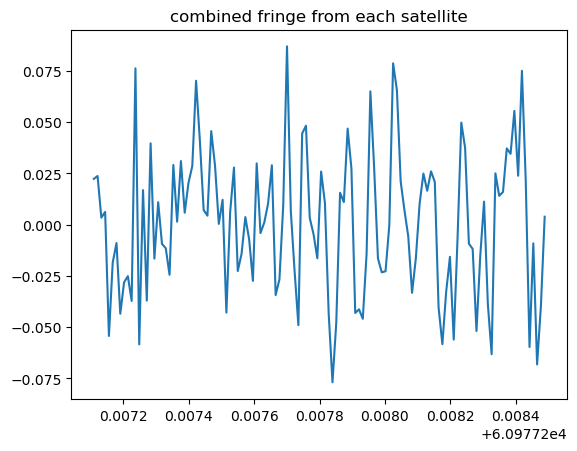

In [55]:
### a example of the combined fringe signal from all satellites
fringes=obs.bw_fringe(delays=delays[1].flatten(),bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100)
# print(fringes)
# fringes[np.where(fringes==0)]=1e-12
plt.title('combined fringe from each satellite')
plt.plot(mjds.flatten(),fringes.reshape(120,-1).mean(1))

In [56]:
sat_fringes=test.sat_fringe(bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=500) ### use the class integrated version
print(sat_fringes.shape)

(3, 1, 1, 1, 120, 56)


(3, 1, 1, 1, 120, 56)


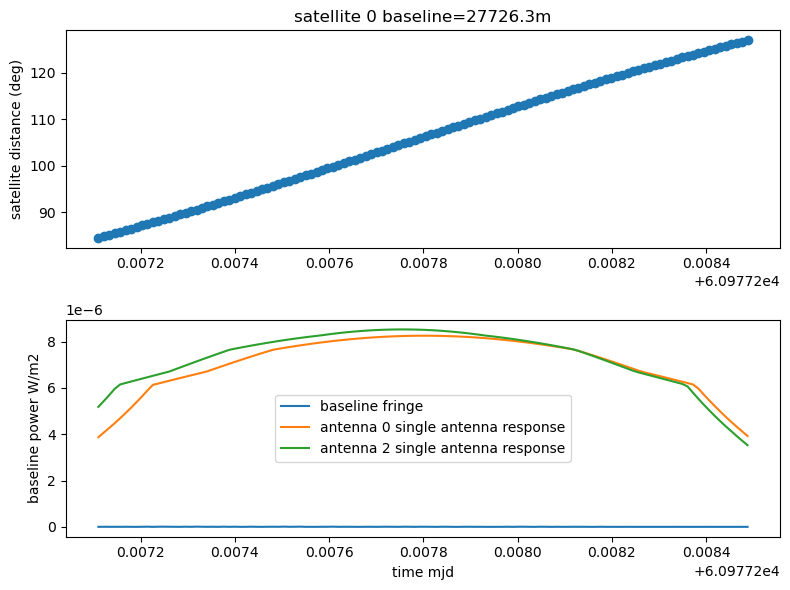

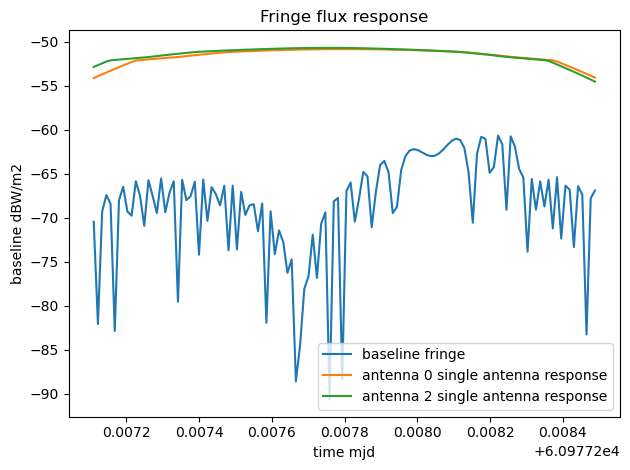

In [ ]:
coherent_v_baselines=np.sqrt(satpwrpfd.value*g_rx.to(cnv.dimless)*(sat_fringes**2)) ###*cnv.dB_W_m2_Hz
print(coherent_v_baselines.shape)

plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
ax1.set_title(f'satellite {nsat} baseline={np.round(test.bearing_D.flatten()[2],2)}m')

ax1.scatter(mjds.flatten(),ang_sep[2,0,0,0,:,nsat])
ax1.set_ylabel('satellite distance (deg)')
ax2=plt.subplot(212)
plt.plot(mjds.flatten(),coherent_v_baselines[0,0,0,0,:,nsat]*coherent_v_baselines[2,0,0,0,:,nsat],label='baseline fringe')
plt.plot(mjds.flatten(),satpwrpfd[0,0,0,0,:,nsat],label='antenna 0 single antenna response')
plt.plot(mjds.flatten(),satpwrpfd[2,0,0,0,:,nsat],label='antenna 2 single antenna response')


plt.legend()
plt.xlabel('time mjd')
plt.ylabel('baseline power W/m2')
# plt.yscale('log')
plt.tight_layout()
plt.show()


plt.title('Fringe flux response')
plt.plot(mjds.flatten(),10*np.log10(coherent_v_baselines[0,0,0,0,:,nsat]*coherent_v_baselines[1,0,0,0,:,nsat]),label='baseline fringe')
plt.plot(mjds.flatten(),10*np.log10(satpwrpfd[0,0,0,0,:,nsat].value),label='antenna 0 single antenna response')
plt.plot(mjds.flatten(),10*np.log10(satpwrpfd[2,0,0,0,:,nsat].value),label='antenna 2 single antenna response')
plt.legend()
plt.xlabel('time mjd')
plt.ylabel('baseline dBW/m2')
# plt.yscale('log')
plt.tight_layout()
plt.show()

# plt.title('Fringe flux response')
# plt.plot(mjds.flatten(),obs.pfd_to_Jy(coherent_v_baselines[0,0,0,0,:,nsat]*coherent_v_baselines[1,0,0,0,:,nsat]),label='baseline fringe')
# plt.plot(mjds.flatten(),obs.pfd_to_Jy(satpwrpfd[0,0,0,0,:,nsat].value),label='antenna 0 single antenna response')
# plt.plot(mjds.flatten(),obs.pfd_to_Jy(satpwrpfd[2,0,0,0,:,nsat].value),label='antenna 2 single antenna response')


# plt.legend()
# plt.xlabel('time mjd')
# plt.ylabel('baseline flux Jy')
# # plt.yscale('log')
# plt.tight_layout()
# plt.show()


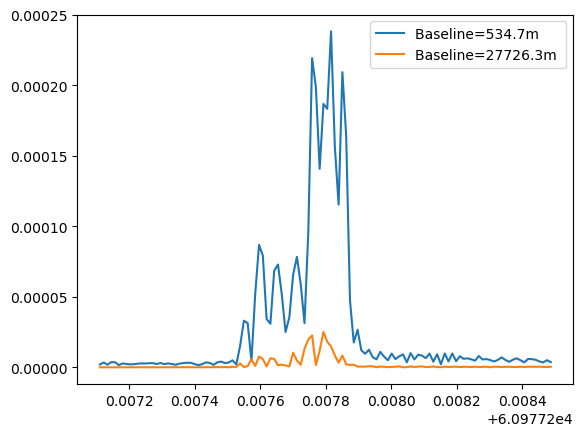

In [58]:
for i in range(len(test.bearing_D)-1):
    fringes=coherent_v_baselines[0]*coherent_v_baselines[i+1]
    plt.plot(mjds.flatten(),fringes.sum(-1).flatten(),label=f"Baseline={np.round(test.bearing_D.flatten()[i+1],1)}m ")
plt.legend()
plt.show()
plt.close()
    

#### calculate the grid response over two different instances of time

In [59]:
#### create the gain change over time
ang_sep=test.sat_separation(mode='allsky')
print(np.argmin(ang_sep[0,0,:,0,:,0],axis=1))

[0 0 0 ... 0 0 0]


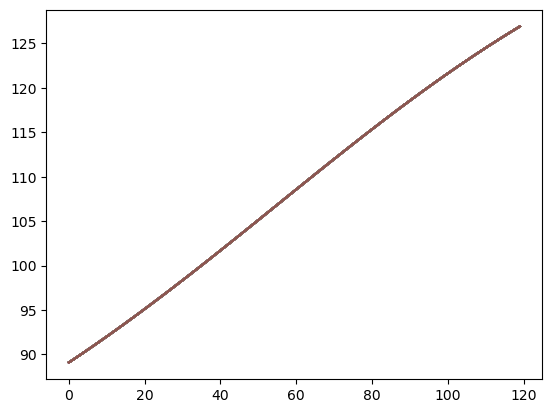

In [60]:
for i in range(ang_sep.shape[5]):
    plt.plot(ang_sep[0,0,1500,0,:,0])
plt.show()


In [61]:
g_rx=antenna.ras_pattern(ang_sep,rx.d_rx,const.c/300e6*u.s,rx.eta_a_rx) ###.to(cnv.dimless) ## get linear

(3, 1, 2334, 1, 120, 56)
(3, 2334, 120)


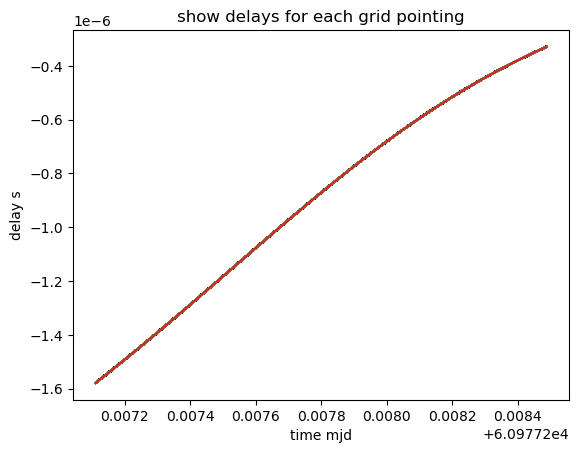

In [62]:
baseline_delays=test.baselines_nearfield_delays(mode='allsky')
print(baseline_delays.shape)
# 

delays=baseline_delays[:,0,:,0,:,0]
print(delays.shape)
plt.title('show delays for each grid pointing')
plt.plot(mjds.flatten(),delays[1].T)
plt.xlabel('time mjd')
plt.ylabel('delay s')
plt.show()

In [63]:
nsat=0

In [1]:
test.baseline_delays=baseline_delays[:,:,:,:,:,:]


NameError: name 'baseline_delays' is not defined

In [67]:
sat_fringes=test.sat_fringe(bwchan=1*u.MHz,fch1=100*u.MHz,chan_bin=100) ### use the class integrated version

: 

In [ ]:
coherent_v_baselines=np.sqrt((satpwrpfd*g_rx.to(cnv.dimless))[:,:,:,:,:,:]*(sat_fringes**2)) ###*cnv.dB_W_m2_Hz
print(coherent_v_baselines.shape)

In [ ]:

vals=(coherent_v_baselines[0,0,1500,0,:]*coherent_v_baselines[1,0,1500,0,:])
plt.plot(mjds.flatten()[np.arange(400,600,1)],vals.T)
plt.show()

In [ ]:
for i in range(test.baseline_delays.shape[4]):
    vals=(coherent_v_baselines[0,0,:,0,i]*coherent_v_baselines[1,0,:,0,i])
    skynet.plotgrid(val=vals,grid_info=test.grid_info,elmin=24,elmax=26,azmin=13,azmax=15,vmin=0.005,vmax=0.035,zlabel='fringe attenuation')
    plt.title(f'sat{nsat} instance {np.arange(0,1000,100)[i]} all sky')
    plt.show()